See if the issues comapring likelihoods of different models can be resolved by creating larger cov matrices

In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [2]:
# Compute a "true" reference covariance matrix
num_images = 1000
num_patches = 1000
edge_crop = 32
# patch_size = 50
patch_size = 10
channel = 'LED119'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, patch_size, num_patches=num_patches)
cov_mat = compute_cov_mat(patches)
cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=1, show_plot=False)
cov_mat_stationary = compute_stationary_cov_mat(patches)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)


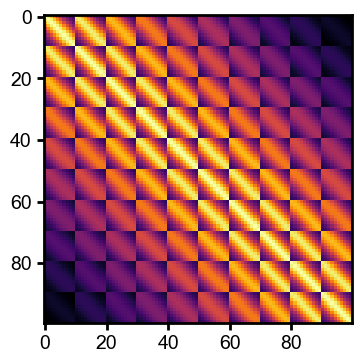

In [3]:
# imshow the stationary pd matrix
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(cov_mat_stationary_pd, cmap='inferno')

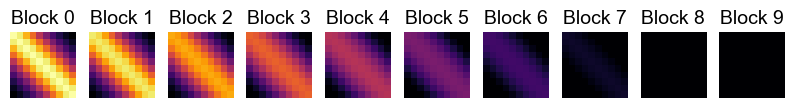

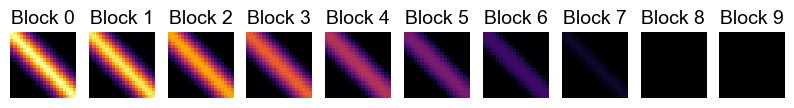

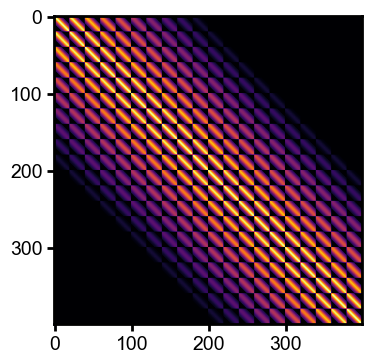

In [26]:
from jax.scipy.linalg import toeplitz


# now expand it to a new patch size
expanded_patch_size = 20

patch_size = int(np.sqrt(cov_mat_stationary_pd.shape[0]))
first_block_row = cov_mat_stationary_pd[:patch_size, :]
n_block = cov_mat_stationary_pd.shape[0] // patch_size
blocks = np.split(first_block_row, n_block, axis=1)


# plot the first block row
vmin, vmax = blocks[0].min(), blocks[0].max()
fig, axs = plt.subplots(1, n_block, figsize=(n_block, 1))
for i, ax in enumerate(axs):
    ax.imshow(blocks[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'Block {i}')

# make list of expanded blocks by expanding each block along its diagonals
expanded_blocks = []
for i, block in enumerate(blocks):
    first_row = block[0, :]
    expanded_first_row = np.concatenate([first_row, np.zeros(expanded_patch_size - patch_size)])
    expanded_block = toeplitz(expanded_first_row)
    expanded_blocks.append(expanded_block)
# add zero blocks
expanded_blocks += [np.zeros((expanded_patch_size, expanded_patch_size)) for _ in range(patch_size, expanded_patch_size)]

# plot the first expanded block row
fig, axs = plt.subplots(1, n_block, figsize=(n_block, 1))
for i, ax in enumerate(axs):
    ax.imshow(expanded_blocks[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'Block {i}')


rows = []
for i in range(len(expanded_blocks)):
    row_blocks = [expanded_blocks[abs(i - j)] for j in range(len(expanded_blocks))]
    row = np.hstack(row_blocks)
    rows.append(row)
expanded_cov_mat = np.vstack(rows)

# plot the full matrix
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(expanded_cov_mat, cmap='inferno')


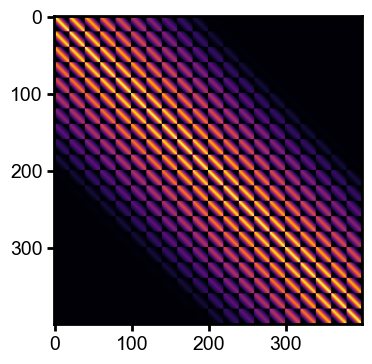

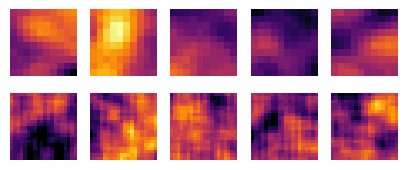

In [34]:
evs = np.linalg.eigvalsh(expanded_cov_mat)

expanded_cov_mat_pd = make_positive_definite(expanded_cov_mat, eigenvalue_floor=1e-8, show_plot=False)

# plot the full matrix
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(expanded_cov_mat_pd, cmap='inferno')

small_sampes = generate_stationary_gaussian_process_samples(cov_mat_stationary_pd, num_samples=5)
samples = generate_stationary_gaussian_process_samples(expanded_cov_mat_pd, num_samples=5)

# plot both
fig, axs = plt.subplots(2, 5, figsize=(5, 2))
vmin, vmax = small_sampes.min(), small_sampes.max()
for i in range(5):
    axs[0, i].imshow(small_sampes[i], cmap='inferno', vmin=vmin, vmax=vmax)
    axs[0, i].axis('off')
    axs[1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
    axs[1, i].axis('off')